In [ ]:
# Import required libraries.
import pandas as pd
import numpy as np
from scipy import optimize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
# mountiong the drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Importing the data from the drive
data=pd.read_csv("/content/drive/My Drive/colab data/bioresponse.csv")
X=data.iloc[:, 1:]
Y=data[['Activity']]
Y.value_counts(normalize=True)

Activity
1           0.542255
0           0.457745
dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.25 , random_state=1234 )

In [ ]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

In [ ]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = np.ones(1)
    
    return w, b

In [ ]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b[0] )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
# optimize

def adam(w, b, X, Y, num_iterations, alpha, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    beta_1=0.9
    beta_2=0.999
    costs = []
    eps=1e-8
    m_w=np.zeros(w.shape)
    v_w=np.zeros(w.shape)

    m_b=np.zeros(b.shape)
    v_b=np.zeros(b.shape)
    grads, cost = propagate(w,b,X,Y)
    costs.append(cost)
    for i in range(1,num_iterations):       

        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]

        m_w = beta_1 * m_w + (1.0 - beta_1) * dw
        v_w = beta_2 * v_w + (1.0 - beta_2) * dw**2
        mhat_w = m_w / (1.0 - beta_1**(i))
        vhat_w =  v_w / (1.0 - beta_2**(i))

        m_b = beta_1 * m_b + (1.0 - beta_1) * db
        v_b = beta_2 * v_b + (1.0 - beta_2) * db**2
        mhat_b = m_b / (1.0 - beta_1**(i))
        vhat_b = v_b / (1.0 - beta_2**(i))
        # Retrieve derivatives from grads
        w=np.subtract(w , alpha*np.divide(mhat_w , (np.sqrt(vhat_w) + eps)))
        b=np.subtract(b , alpha*np.divide(mhat_b , (np.sqrt(vhat_b) + eps)))
        # update rule

        
        # Record the costs
        #if i % 10 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b[0])
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction
    

In [ ]:
# model

def model(X_train, Y_train, X_test, Y_test, optimize, num_iterations, learning_rate , print_cost = False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    np.random.seed(1234)
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    accuracy_train=(100 - np.mean((np.abs(Y_prediction_train - Y_train)).values) * 100)
    accuracy_test=(100 - np.mean((np.abs(Y_prediction_test - Y_test)).values) * 100)
    accuracy={'train': accuracy_train, 'test':accuracy_test }

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return accuracy, parameters, grads, costs

Adams Model
Accurecy of the model for learning rate: 0.5
{'train': 90.79274795591894, 'test': 74.09381663113007}
Accurecy of the model for learning rate: 0.1
{'train': 86.77568432278706, 'test': 75.79957356076758}
Accurecy of the model for learning rate: 0.05
{'train': 85.67365801635265, 'test': 76.11940298507463}
Accurecy of the model for learning rate: 0.01
{'train': 84.46498400284393, 'test': 75.79957356076758}
Accurecy of the model for learning rate: 0.005
{'train': 83.29185922502666, 'test': 75.05330490405117}


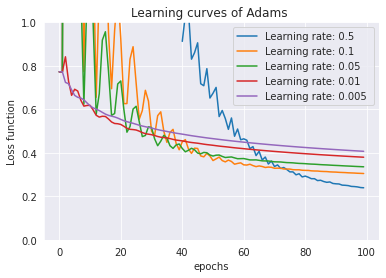

In [ ]:
# Plotting the learning curve for adam model for the learning values =[0.5, 0.05, 0.005, 0.0005, 0.00005]
# Caluclating the accuracy of the adam model for different learning rates
accuracy_adam=[]
cost_adam=[]
num_iterations = 100
np.random.seed(1234)
print('Adams Model')
j=[0.5,0.1,0.05,0.01,0.005]
for i in j:
  np.random.seed(1234)
  dim = 1776
  w, b = initialize_with_zeros(dim)
  accuracy, params, grads, costs = model(X_train.T, Y_train.T, X_test.T, Y_test.T, adam, num_iterations , i, print_cost = False)
  cost_adam.append(costs)
  accuracy_adam.append(accuracy)
  print('Accurecy of the model for learning rate: {}'.format(i))
  print(accuracy)
  plt.plot(np.arange(len(costs)), costs, label='Learning rate: {} '.format(i))
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('Loss function')
  plt.title('Learning curves of Adams ')
plt.ylim(0, 1)
plt.show()